In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.signal import medfilt as MF
from scipy.stats import scoreatpercentile as sap
from scipy.optimize import fmin, fmin_powell
from itertools import chain

%run ../src/core.py
%run ../src/lpf.py
%run ../extcore.py
%run -i lpf_broadband.py

result_file_c = '../results/osiris'
run_name =  '/bb/vkwn_constrained'
seed(0)

N = lambda a: a/median(a)

In [3]:
lpf = LPFC(noise='white', constant_k=False, use_ldtk=False)

In [4]:
de = DiffEvol(lpf.lnposterior, lpf.ps.bounds, 300, maximize=True, F=0.5, C=0.1)

for i,p in enumerate(lpf.ps.priors[0:4]):
    de._population[:,i] = normal(p.mean, p.std, size=de.n_pop)
    
for iq in chain(lpf.iq1,lpf.iq2):
    p = lpf.ps.priors[iq]
    de._population[:,iq] = normal(p.mean, 2*p.std, size=de.n_pop)
    
de._population[:,unique(lpf.ik2)] = uniform(0.165**2, 0.175**2, size=(de.n_pop, lpf.npb))

In [5]:
def gpids(i):
    return [lpf.ibla[i], lpf.iblb[i], lpf.ibld[i]] + lpf.iblr + [lpf.iwn[i]]
    
def modfun(pv, i):
    pids = gpids(i)
    pva = zeros(de.n_par)
    pva[pids] = pv
    bl = lpf.compute_baseline(pva)
    return bl[i]
        
def minfun(pv, i):
    m = ~lpf.otmasks[i]
    lnprior = sum([lpf.ps.priors[j].log(v) for j,v in zip(pids,pv)])
    lnlike  = ll_normal_es(lpf.fluxes[i][m], modfun(pv,i)[m], 0.001)
    return -(lnprior + lnlike)

In [6]:
pvbl = []
for i in range(lpf.nlc):
    pids = gpids(i)
    dem = DiffEvol(lambda pv:minfun(pv,i), lpf.ps.bounds[pids,:], 50)
    dem.optimize(400)
    pvbl.append(dem.population.copy())

In [17]:
for i in range(lpf.nlc):
    pids = gpids(i)
    de._population[:,pids[:-1]] = repeat(pvbl[i][:,:-1], 6, axis=0)

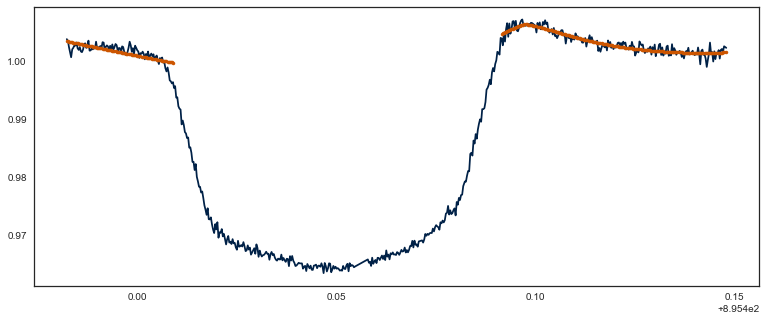

In [18]:

bl = modfun(dem.minimum_location, i)
m = ~lpf.otmasks[i]
plot(lpf.times[i], lpf.fluxes[i])
plot(lpf.times[i][m], bl[m], '.')

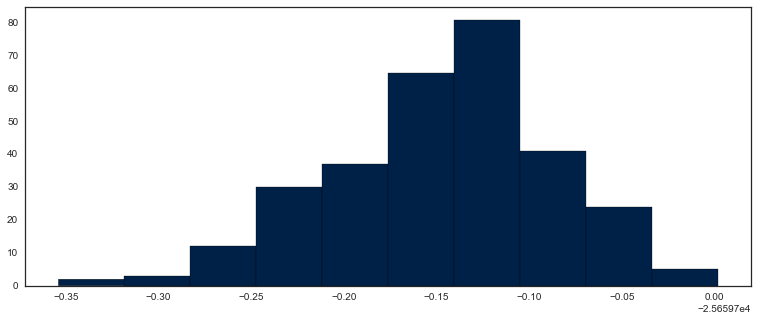

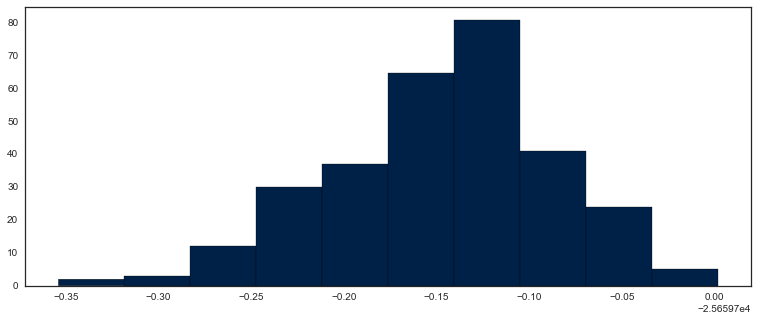

In [5]:
de.F = 0.25
de.C = 0.85
niter = 750
fig,ax = subplots(1,1)

try:
    for i,r in enumerate(de(niter)):
        if ((i+1)%20 == 0) or (i==niter-1):
            ax.cla()
            ax.hist(de._fitness)
            clear_output(wait=True)
            display(HTML('DE Iteration {:4d} max lnlike {:7.1f} med {:7.1f}'.format(i+1,-de.minimum_value,median(-de._fitness))))
            display(fig)
        if ((i+1)%5 == 0) and (i>120):
            for j in range(1):
                ipv = randint(0,high=de.n_pop)
                #pv = fmin(lambda pv: -lpf.lnposterior(pv), de.population[ipv], disp=True)
                #de._population[ipv,:] = pv
except KeyboardInterrupt:
    pass
finally:
    dfde = pd.DataFrame(de.population, columns=lpf.ps.names)
    dfde.to_hdf(result_file_c,'{:s}/de'.format(run_name))

-14409.7785843


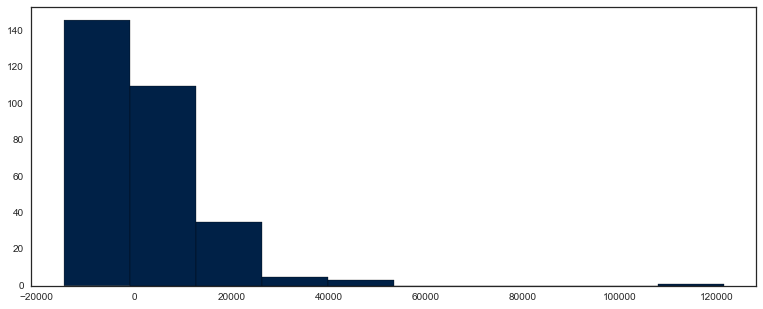

In [11]:
hist(de._fitness)
print de.minimum_value

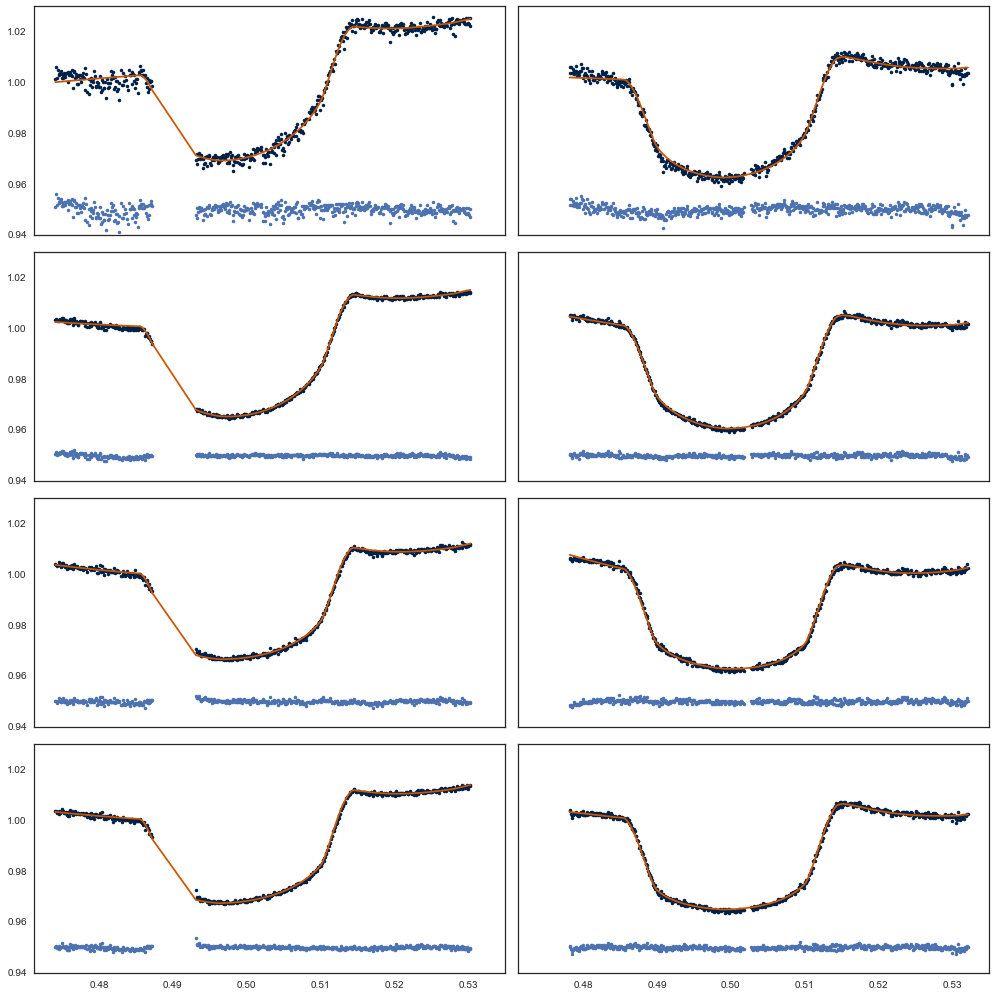

In [26]:
pv = de.minimum_location.copy()
fms = lpf.compute_lc_model(pv)
fos = lpf.fluxes
fig,axs = subplots(4,2,figsize=(14,14), sharey=True, sharex=True)
for i in range(2):
    for j in range(4):
        ilc = 4*i+j
        phase = fold(lpf.times[ilc], pv[1], pv[0], 0.5)
        res = fos[ilc]-fms[ilc]
        axs[j,i].plot(phase, fos[ilc], '.')
        axs[j,i].plot(phase, fms[ilc])
        axs[j,i].plot(phase, res+0.95, '.')
setp(axs, ylim=(0.94,1.03))
fig.tight_layout()

In [27]:
sampler = EnsembleSampler(de.n_pop, de.n_par, lpf.lnposterior)

In [28]:
sampler.run_mcmc(de.population, 150);

In [49]:
sampler.run_mcmc(sampler.chain[:,-1,:], 10000);

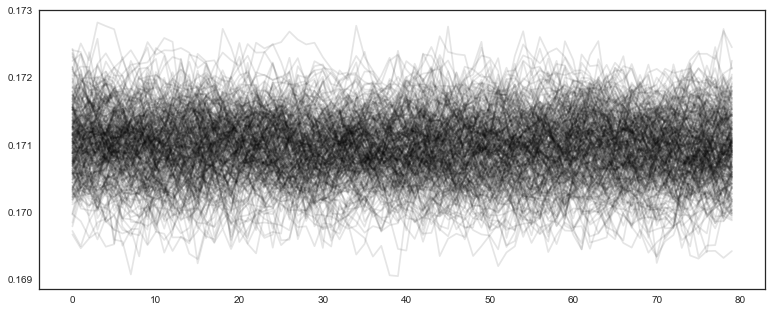

In [54]:
plot(sqrt(sampler.chain[:,5000::100,4].T), 'k', alpha=0.1);

In [64]:
fc = pd.read_hdf(join('..',result_file), 'vkrn_ldtk/fc')

In [59]:
dff = pd.DataFrame(sampler.chain[:,5000::200,:].reshape([-1,lpf.ps.ndim]), columns=lpf.ps.names)

In [41]:
dff.columns

Index([u'tc', u'p', u'rho', u'b', u'k2_g', u'k2_r', u'k2_i', u'k2_z', u'q1_g',
       u'q2_g', u'q1_r', u'q2_r', u'q1_i', u'q2_i', u'q1_z', u'q2_z', u'bla_0',
       u'blb_0', u'blz_0', u'bla_1', u'blb_1', u'blz_1', u'bla_2', u'blb_2',
       u'blz_2', u'bla_3', u'blb_3', u'blz_3', u'bla_4', u'blb_4', u'blz_4',
       u'bla_5', u'blb_5', u'blz_5', u'bla_6', u'blb_6', u'blz_6', u'bla_7',
       u'blb_7', u'blz_7', u'e_0', u'e_1', u'e_2', u'e_3', u'e_4', u'e_5',
       u'e_6', u'e_7', u'bl_ra_l', u'bl_ra_ea', u'bl_ra_er0', u'bl_ra_epw',
       u'bl_ra_ewd'],
      dtype='object')

In [60]:
dff.shape

(12000, 53)

In [62]:
dff.to_hdf(result_file_c,'{:s}/fc'.format(run_name))

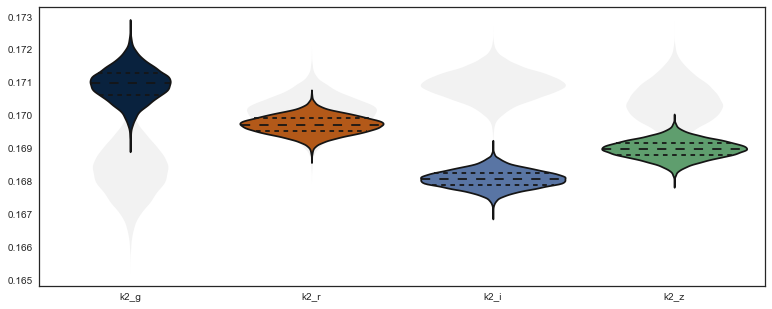

In [76]:
sb.violinplot(sqrt(fc['k2_g k2_r k2_i k2_z'.split()]), inner=None, color='0.95', linewidth=0)
sb.violinplot(sqrt(dff['k2_g k2_r k2_i k2_z'.split()]), inner='quartiles')

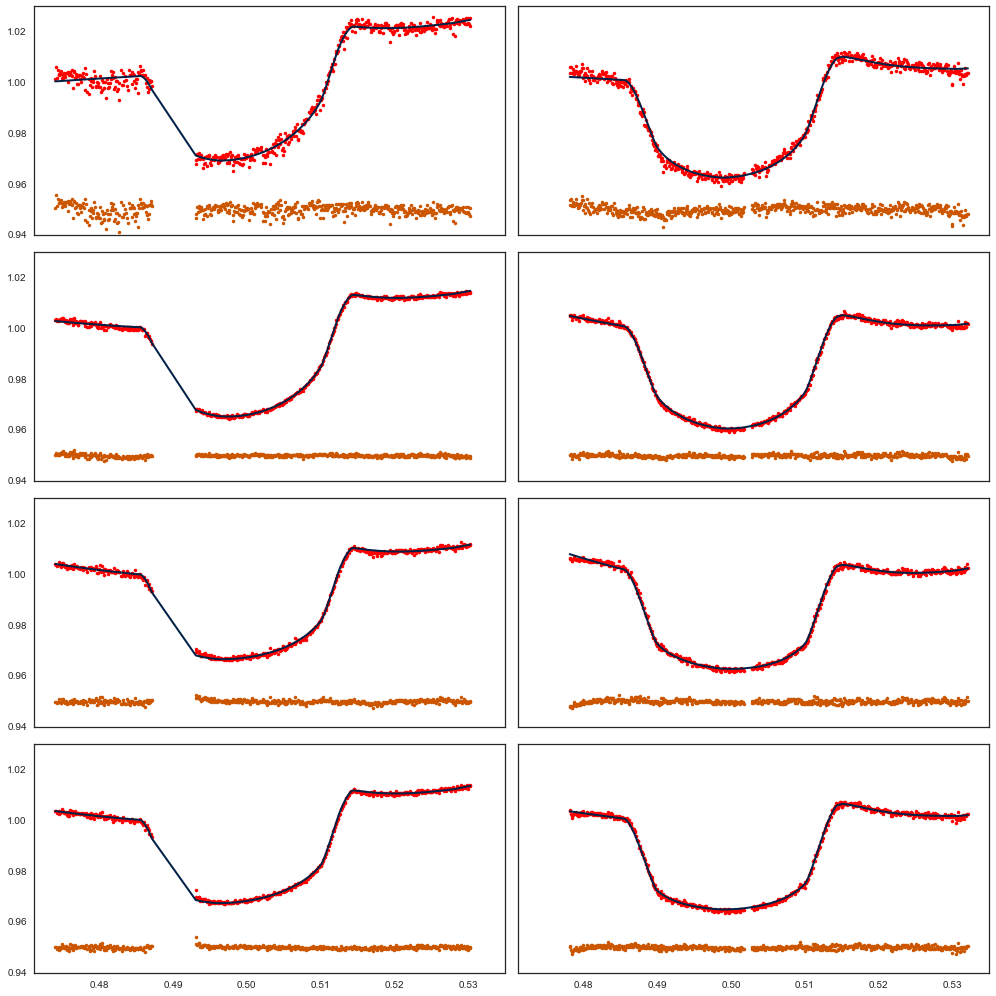

In [57]:
pv = median(dff.values, 0)
fms = lpf.compute_lc_model(pv)
fos = lpf.fluxes
fig,axs = subplots(4,2,figsize=(14,14), sharey=True, sharex=True)
for i in range(2):
    for j in range(4):
        ilc = 4*i+j
        phase = fold(lpf.times[ilc], pv[1], pv[0], 0.5)
        res = fos[ilc]-fms[ilc]
        axs[j,i].plot(phase, fos[ilc], 'r.')
        axs[j,i].plot(phase, fms[ilc], lw=2)
        axs[j,i].plot(phase, res+0.95, '.')
setp(axs, ylim=(0.94,1.03))
fig.tight_layout()